In [1]:
import nltk

In [2]:
import sys
import numpy as np
import pandas as pd
import subprocess
import pkg_resources
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

/Users/koberong0917/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  """


# Section 1: Read in the dataset and do text preprocessing

In [3]:
companies = pd.read_csv('CompaniesPostStemming.csv')

In [4]:
companies

,Unnamed: 0,Unnamed: 0.1,index,ticker,cik,formType,year,finalText,count
0,0,0,0,A,1090872,10-K,2021,item risk factor busi strateg risk covid pande...,32764
1,1,1,1,AVGO,1730168,10-K,2021,item risk factor busi oper financi result subj...,30716
2,2,2,2,AMAT,6951,10-K,2021,item risk factor follow risk factor materi adv...,23672
3,3,3,3,ADI,6281,10-K,2021,item risk factor set forth report document fil...,23783
4,4,4,4,BDX,10795,10-K,2021,item risk factor invest bd involv varieti risk...,24944
...,...,...,...,...,...,...,...,...,...
4405,4455,4455,3018,IBM,51143,10-Q,2022,item risk factor amend follow risk factor disc...,13447
4406,4456,4456,3019,ISRG,1035267,10-Q,2022,item ri sk factor care consid factor discuss i...,5524
4407,4457,4457,3020,LVS,1300514,10-Q,2022,item risk factor amend follow risk factor disc...,13502
4408,4458,4458,3021,IQV,1478242,10-Q,2022,item risk factor addit inform set forth form c...,8223


In [5]:
#Add the data of the same company to create on long string of all filings over the 2 years
tickers = companies['ticker'].unique()
len(tickers)

496

In [6]:
count = 0
companies2 = pd.DataFrame(columns=['ticker', 'text'])
for i in tickers:
    temp = companies[companies['ticker'] == i]
    companies2.loc[count] = [i, temp['finalText'].str.cat(sep = ' ')]
    count+=1

In [7]:
companies2

,ticker,text
0,A,item risk factor busi strateg risk covid pande...
1,AVGO,item risk factor busi oper financi result subj...
2,AMAT,item risk factor follow risk factor materi adv...
3,ADI,item risk factor set forth report document fil...
4,BDX,item risk factor invest bd involv varieti risk...
...,...,...
491,CEG,item risk factor table_end oper complex market...
492,OGN,item risk factor care consid follow risk infor...
493,GEHC,item risk factor summari risk factor invest co...
494,C,item manag discuss analysi financi condit resu...


In [8]:
companies2['count'] = [len(text.split(' ')) for text in companies2['text']]

In [9]:
companies2.head()

,ticker,text,count
0,A,item risk factor busi strateg risk covid pande...,70971
1,AVGO,item risk factor busi oper financi result subj...,67580
2,AMAT,item risk factor follow risk factor materi adv...,86897
3,ADI,item risk factor set forth report document fil...,66876
4,BDX,item risk factor invest bd involv varieti risk...,57919


# Section 2: Compute PMI matrix

## Method 1: Compute PMI matrix and apply Singular Value Decomposition (SVD) on it

In order to compute numeric vectors for words, we will need to construct the PMI matrix. To do this, we first need to compute the frequency of skip-grams, which are just generalizations of n-grams that allow tokens to be skipped within some specified window. Think of it as computing the frequency of times a pair of words are observed together within some defined window indicating how far apart the tokens are allowed at max to be apart from each other.

The following code shows how we can use the CountVectorizer from sklearn to count skip-grams of two words, with a window of four tokens:

In [10]:
from functools import partial

from nltk.util import skipgrams
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

skip4_bigrams = partial(skipgrams, n = 2, k = 4)

def my_analyzer(text):
    return skip4_bigrams(word_tokenize(text))

skipgram_vectorizer = CountVectorizer(analyzer = my_analyzer, token_pattern = '[a-zA-Z]+')
skipgram_count_matrix = skipgram_vectorizer.fit_transform(companies2.text)

For ease, we'll convert this into a DataFrame and see how exactly it's stored:

In [ ]:
skipgram_df = pd.DataFrame(skipgram_count_matrix.toarray(),
                           columns = skipgram_vectorizer.get_feature_names_out())
skipgram_df.head()

In [ ]:
#Remove all the columns with underscore inside
def contains_underscore(x):
    #x is a tuple of two elements, just like what the column looks like above
    return (('_' in x[0]) or ('_' in x[1]))

# Get a list of column names without underscores
columns_to_keep = [col for col in skipgram_df.columns if not contains_underscore(col)]

skipgram_df_2 = skipgram_df[columns_to_keep]

In [ ]:
skipgram_df_2.head()

In [ ]:
skipgram_long = pd.DataFrame({'counts': skipgram_df_2.sum(axis = 0).values})

skipgram_long[['term1', 'term2']] = pd.DataFrame(skipgram_df_2.columns.tolist(),
                                                index = skipgram_long.index)

In [ ]:
skipgram_long

In [ ]:
full_pairs_df = skipgram_long

In [ ]:
full_pairs_df['skip_p'] = full_pairs_df['counts'] / full_pairs_df['counts'].sum()

In [ ]:
unigram_vectorizer = CountVectorizer(token_pattern = '[a-zA-Z]+')
unigram_count_matrix = unigram_vectorizer.fit_transform(companies2.text)

In [ ]:
unigram_long = pd.DataFrame({'uni_freq1': unigram_count_matrix.toarray().sum(axis = 0),
                             'term1': unigram_vectorizer.get_feature_names_out()})
unigram_long['uni_freq1'] = unigram_long['uni_freq1'] / unigram_long['uni_freq1'].sum()

In [ ]:
unigram_long

In [ ]:
unigram_long2 = unigram_long.rename(columns = {"uni_freq1": "uni_freq2", "term1": "term2"})

In [ ]:
full_pairs_df = full_pairs_df.merge(unigram_long, how = "left", left_on = "term1", right_on = "term1")

In [ ]:
full_pairs_df = full_pairs_df.merge(unigram_long2, how = "left", left_on = "term2", right_on = "term2")

In [ ]:
full_pairs_df

In [ ]:
full_pairs_df['pmi'] = np.log(full_pairs_df['skip_p'] / full_pairs_df['uni_freq1'] / full_pairs_df['uni_freq2'])

# Replace anything below 0 with 0, tend to focus on positive direction more than expected:
full_pairs_df['pmi'] = np.maximum(full_pairs_df['pmi'], 0)

In [ ]:
skipgram_wide_matrix = pd.pivot_table(full_pairs_df, index='term1', columns='term2', values='pmi',
                                      fill_value = 0).values

# Section 3: Employ Singular Value Decomposition (SVD) to extract embeddings 

In [30]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

In [31]:
skipgram_sparse = csr_matrix(skipgram_wide_matrix)
svd = TruncatedSVD(n_components = 500, n_iter = 10, random_state = 42)

In [32]:
svd_embeddings = svd.fit_transform(skipgram_sparse)

In [40]:
svd_embeddings

array([[ 9.25588323e+00,  1.76992398e+00,  1.24162827e+00, ...,
        -6.92995685e-01,  1.16014084e+00, -1.21337798e+00],
       [ 6.38951596e+00,  2.14519861e+00, -6.39541062e-01, ...,
        -1.41011830e+00,  1.99236515e+00, -1.72457230e-01],
       [ 6.44289672e-01, -7.02163711e-01,  3.62206476e-01, ...,
        -3.10380918e-01, -6.46617090e-02, -4.99196952e-02],
       ...,
       [ 1.00831329e+00,  2.04783280e-01, -3.51181893e-02, ...,
        -2.15258085e-01, -1.05845039e+00, -7.58767388e-02],
       [ 1.67823447e+00, -2.74464074e+00,  2.88170258e+00, ...,
        -7.71878420e-03, -4.27590602e-01, -1.03235334e+00],
       [ 8.80346421e-01, -5.36095083e-03, -3.69670554e-02, ...,
        -2.94396665e-02, -3.65590336e-01,  3.92770663e-01]])

In [38]:
svd_embeddings.shape

(41092, 500)

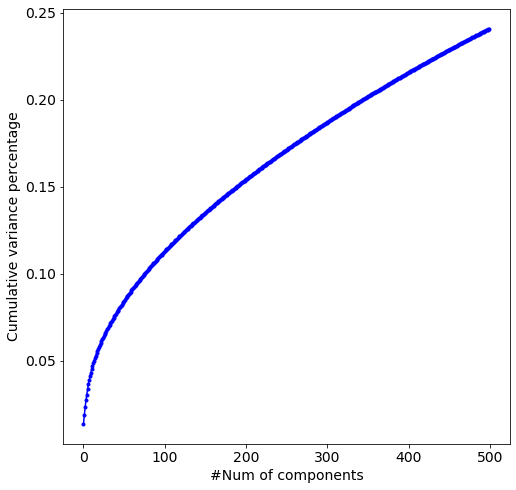

In [33]:
# plot to figure out the variance ratio explained by the reduced dimensions
explained = svd.explained_variance_ratio_.cumsum()
plt.figure(figsize = (8, 8))
plt.plot(explained, '.-', ms = 6, color = 'b')
plt.xlabel('#Num of components', fontsize = 14)
plt.ylabel('Cumulative variance percentage', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [34]:
svd_embeddings.shape

(41092, 500)

In [35]:
svd.components_.shape

(500, 41092)

In [36]:
word_embeddings_df = pd.DataFrame(np.transpose(svd_embeddings))

In [23]:
# Get the after SVD data locally
word_embeddings_df = pd.read_csv('after_svd_data.csv',index_col=False)
word_embeddings_df 

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,aa,9.255883,1.769924,1.241628,5.011388,0.066564,-0.636492,-3.622085,1.333511,-4.536455,...,1.109914,0.722581,1.620864,-0.960518,0.355200,-0.991385,0.630485,-0.692996,1.160141,-1.213378
1,aaa,6.389516,2.145199,-0.639541,3.083041,-1.559510,0.067416,-3.289708,0.244010,-1.987705,...,-0.525557,1.574668,0.979504,-0.226261,0.204011,0.380543,0.472173,-1.410118,1.992365,-0.172457
2,aaac,0.644290,-0.702164,0.362206,-0.379746,-0.209510,0.360580,0.202802,0.357664,0.563807,...,-0.139466,0.540914,-0.084222,0.598236,-0.218767,0.067407,0.600276,-0.310381,-0.064662,-0.049920
3,aaadm,0.448013,-0.030759,-0.151096,-0.239444,-0.205642,0.304952,0.284104,0.429880,0.086526,...,0.220527,0.051214,-0.152237,-0.135276,0.006501,0.197945,-0.169282,0.351040,0.052436,-0.616780
4,aaahc,0.594674,0.002828,0.057213,0.257551,-0.620585,-0.441687,-0.136455,0.439152,0.049168,...,0.047278,-0.138303,-0.180136,-0.248511,0.154792,0.314535,-0.263482,-0.045039,0.016101,-0.242532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41087,zyprexa,0.915133,-1.159992,0.991467,0.434015,-0.437394,0.618387,-0.186943,0.696361,-0.436872,...,0.696246,-0.635962,0.180057,-0.019365,-0.050804,-0.405842,0.716507,0.410896,-0.474828,-0.502802
41088,zyrtec,1.489326,-0.570715,0.437993,-0.488484,-0.300637,0.234007,-0.494450,0.307671,-0.349598,...,-0.748869,-1.027240,-0.207919,-0.735310,0.304158,0.447815,-0.784783,-0.351282,-0.679355,0.921986
41089,zytel,1.008313,0.204783,-0.035118,0.029864,-0.523927,1.054928,0.601893,1.042698,-0.116122,...,-0.481059,-0.555995,-0.286949,0.181796,0.149880,0.741319,-0.059260,-0.215258,-1.058450,-0.075877
41090,zytiga,1.678234,-2.744641,2.881703,1.426496,-0.601354,0.575136,-0.870855,0.975906,-0.592289,...,-0.618296,0.731059,0.345944,0.287269,-0.845830,0.421257,0.463517,-0.007719,-0.427591,-1.032353


In [25]:
word_embeddings_df = word_embeddings_df.set_index('Unnamed: 0')

In [26]:
word_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
aa,9.255883,1.769924,1.241628,5.011388,0.066564,-0.636492,-3.622085,1.333511,-4.536455,-2.531171,...,1.109914,0.722581,1.620864,-0.960518,0.355200,-0.991385,0.630485,-0.692996,1.160141,-1.213378
aaa,6.389516,2.145199,-0.639541,3.083041,-1.559510,0.067416,-3.289708,0.244010,-1.987705,-0.939372,...,-0.525557,1.574668,0.979504,-0.226261,0.204011,0.380543,0.472173,-1.410118,1.992365,-0.172457
aaac,0.644290,-0.702164,0.362206,-0.379746,-0.209510,0.360580,0.202802,0.357664,0.563807,0.039299,...,-0.139466,0.540914,-0.084222,0.598236,-0.218767,0.067407,0.600276,-0.310381,-0.064662,-0.049920
aaadm,0.448013,-0.030759,-0.151096,-0.239444,-0.205642,0.304952,0.284104,0.429880,0.086526,-0.172239,...,0.220527,0.051214,-0.152237,-0.135276,0.006501,0.197945,-0.169282,0.351040,0.052436,-0.616780
aaahc,0.594674,0.002828,0.057213,0.257551,-0.620585,-0.441687,-0.136455,0.439152,0.049168,-0.073333,...,0.047278,-0.138303,-0.180136,-0.248511,0.154792,0.314535,-0.263482,-0.045039,0.016101,-0.242532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zyprexa,0.915133,-1.159992,0.991467,0.434015,-0.437394,0.618387,-0.186943,0.696361,-0.436872,0.095209,...,0.696246,-0.635962,0.180057,-0.019365,-0.050804,-0.405842,0.716507,0.410896,-0.474828,-0.502802
zyrtec,1.489326,-0.570715,0.437993,-0.488484,-0.300637,0.234007,-0.494450,0.307671,-0.349598,0.859806,...,-0.748869,-1.027240,-0.207919,-0.735310,0.304158,0.447815,-0.784783,-0.351282,-0.679355,0.921986
zytel,1.008313,0.204783,-0.035118,0.029864,-0.523927,1.054928,0.601893,1.042698,-0.116122,0.334164,...,-0.481059,-0.555995,-0.286949,0.181796,0.149880,0.741319,-0.059260,-0.215258,-1.058450,-0.075877


In [27]:
# Define helper function to perform this operation, based on being provided an embedding "model" with terms that can be looked up 
def get_word_vector(document, model, n_dim):
    wv = np.zeros(n_dim) # init array same size as provided n_dim
    n = 0 # number of words with word vector
    
    # iterate over the words in the document
    tokens = nltk.word_tokenize(document)
 
    for word in tokens:
        if word.lower() in model:
            wv = np.add(wv, model[word.lower()].values)
            n += 1
    if n > 0:
        wv = np.divide(wv, n)
    return wv

In [28]:
doc_embeddings_df = pd.concat([pd.DataFrame(
    get_word_vector(doc, word_embeddings_df.T, 500).reshape(-1, 500))
                               for doc in companies2.text])

KeyboardInterrupt: 

In [63]:
doc_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,15.384309,0.524025,-1.562666,2.637552,6.525714,-2.088027,4.469692,-0.460677,-4.367443,-1.356536,...,-0.060658,-0.057085,-0.113533,0.039873,0.042869,-0.050282,-0.068013,0.121577,0.056805,0.168608
0,15.810666,0.336216,-2.254565,2.006872,6.358235,-2.453789,5.106705,-0.726600,-3.905514,-1.462621,...,0.004288,-0.066299,-0.096962,0.096489,-0.001643,-0.046113,-0.093698,0.142833,0.030629,0.104804
0,14.974855,0.517159,-1.573451,3.003091,6.186452,-2.702409,4.510411,-0.396755,-4.604499,-1.426029,...,-0.041997,-0.073983,-0.082305,0.031860,0.021996,-0.115495,-0.074902,0.091412,0.003821,0.222056
0,15.257140,0.562540,-2.202496,2.608895,6.035110,-2.430245,4.616534,-0.827875,-4.712600,-1.204266,...,-0.026860,-0.040204,-0.020687,0.017301,0.017640,-0.074695,-0.140490,0.132774,-0.018277,0.135225
0,16.023791,-0.167078,-1.703496,2.387038,6.387316,-2.412521,4.830902,-1.023048,-4.047209,-0.896743,...,0.018795,-0.046212,0.008455,0.041283,0.006523,-0.061789,-0.064546,0.099149,0.012761,0.067540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,15.352670,1.036830,-2.251177,4.005275,5.598785,-2.838979,4.408252,-1.402996,-3.863510,-1.523303,...,-0.143913,-0.077968,-0.010343,0.001577,-0.066612,-0.019685,-0.067460,0.093489,0.014201,0.094745
0,16.666632,-1.254645,-0.640011,3.258495,6.046219,-2.799803,4.374553,-1.267268,-4.149193,-0.881180,...,0.085199,-0.085253,-0.020633,0.064669,-0.012082,-0.061646,-0.116285,0.126138,0.019874,0.126357
0,16.977556,-0.239772,-1.240980,1.822356,6.724667,-3.428695,4.578567,-1.042403,-2.664034,-1.001466,...,0.095579,-0.032385,-0.056140,0.083362,0.071735,-0.013015,-0.034682,0.117731,0.027245,0.086476
0,14.279448,1.173641,-1.859292,3.465509,6.386624,-2.035278,4.122844,-0.249697,-6.097787,-1.529636,...,-0.049384,-0.029612,-0.047240,-0.023960,0.008137,-0.039945,-0.095568,0.101194,0.031428,0.162647


In [66]:
doc_embeddings_df.index = companies2.ticker

In [67]:
doc_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
ticker,,,,,,,,,,,,,,,,,,,,,
A,15.384309,0.524025,-1.562666,2.637552,6.525714,-2.088027,4.469692,-0.460677,-4.367443,-1.356536,...,-0.060658,-0.057085,-0.113533,0.039873,0.042869,-0.050282,-0.068013,0.121577,0.056805,0.168608
AVGO,15.810666,0.336216,-2.254565,2.006872,6.358235,-2.453789,5.106705,-0.726600,-3.905514,-1.462621,...,0.004288,-0.066299,-0.096962,0.096489,-0.001643,-0.046113,-0.093698,0.142833,0.030629,0.104804
AMAT,14.974855,0.517159,-1.573451,3.003091,6.186452,-2.702409,4.510411,-0.396755,-4.604499,-1.426029,...,-0.041997,-0.073983,-0.082305,0.031860,0.021996,-0.115495,-0.074902,0.091412,0.003821,0.222056
ADI,15.257140,0.562540,-2.202496,2.608895,6.035110,-2.430245,4.616534,-0.827875,-4.712600,-1.204266,...,-0.026860,-0.040204,-0.020687,0.017301,0.017640,-0.074695,-0.140490,0.132774,-0.018277,0.135225
BDX,16.023791,-0.167078,-1.703496,2.387038,6.387316,-2.412521,4.830902,-1.023048,-4.047209,-0.896743,...,0.018795,-0.046212,0.008455,0.041283,0.006523,-0.061789,-0.064546,0.099149,0.012761,0.067540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CEG,15.352670,1.036830,-2.251177,4.005275,5.598785,-2.838979,4.408252,-1.402996,-3.863510,-1.523303,...,-0.143913,-0.077968,-0.010343,0.001577,-0.066612,-0.019685,-0.067460,0.093489,0.014201,0.094745
OGN,16.666632,-1.254645,-0.640011,3.258495,6.046219,-2.799803,4.374553,-1.267268,-4.149193,-0.881180,...,0.085199,-0.085253,-0.020633,0.064669,-0.012082,-0.061646,-0.116285,0.126138,0.019874,0.126357
GEHC,16.977556,-0.239772,-1.240980,1.822356,6.724667,-3.428695,4.578567,-1.042403,-2.664034,-1.001466,...,0.095579,-0.032385,-0.056140,0.083362,0.071735,-0.013015,-0.034682,0.117731,0.027245,0.086476


In [81]:
# use cosine_similarity to find similar companies
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(doc_embeddings_df)
similarities = pd.DataFrame(similarities)
similarities.columns = companies2.ticker
similarities.index = companies2.ticker
similarities

ticker,A,AVGO,AMAT,ADI,BDX,COR,APD,ATO,AAPL,AZO,...,SLB,ZION,ZBH,ZTS,GOOG,CEG,OGN,GEHC,C,MA
ticker,,,,,,,,,,,,,,,,,,,,,
A,1.000000,0.990636,0.993725,0.994290,0.993132,0.993014,0.987701,0.987644,0.980530,0.994555,...,0.992010,0.984339,0.985629,0.988996,0.985125,0.984085,0.971257,0.974396,0.984081,0.992598
AVGO,0.990636,1.000000,0.989514,0.993749,0.994199,0.987953,0.973737,0.980282,0.983027,0.988489,...,0.983016,0.973655,0.978620,0.992495,0.993812,0.979048,0.974489,0.984062,0.965524,0.987651
AMAT,0.993725,0.989514,1.000000,0.995667,0.988250,0.995455,0.987675,0.988717,0.978695,0.991732,...,0.989454,0.992342,0.994364,0.986092,0.981588,0.985732,0.967636,0.970161,0.983654,0.988984
ADI,0.994290,0.993749,0.995667,1.000000,0.993289,0.995431,0.987750,0.988159,0.985098,0.994741,...,0.991446,0.988019,0.988424,0.990548,0.988187,0.986667,0.971524,0.974504,0.982481,0.992855
BDX,0.993132,0.994199,0.988250,0.993289,1.000000,0.988633,0.976739,0.980297,0.982865,0.991120,...,0.984972,0.973788,0.978700,0.994809,0.990701,0.980151,0.983683,0.986882,0.969365,0.987434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CEG,0.984085,0.979048,0.985732,0.986667,0.980151,0.990007,0.981847,0.989643,0.969131,0.985965,...,0.984926,0.981162,0.981967,0.978512,0.973827,1.000000,0.962814,0.965116,0.972261,0.984173
OGN,0.971257,0.974489,0.967636,0.971524,0.983683,0.967160,0.945072,0.955415,0.960863,0.969472,...,0.958102,0.948423,0.959158,0.983561,0.971869,0.962814,1.000000,0.982327,0.939741,0.960914
GEHC,0.974396,0.984062,0.970161,0.974504,0.986882,0.971455,0.942876,0.956224,0.966066,0.969617,...,0.960258,0.947188,0.962054,0.986030,0.986412,0.965116,0.982327,1.000000,0.932003,0.962082


In [48]:
# this function finds the top k similar companies to the company in interest
def topKSimilarCompanies(similarities, k):
    all_list = []
    for i in range(similarities.shape[0]):
        list1 = similarities.iloc[:,i].sort_values(ascending=False)[1:k]
        all_list.append(list1)
    return all_list

In [95]:

topKSimilarCompanies(similarities, 3)

[ticker
 ECL     0.995987
 ALLE    0.995616
 Name: A, dtype: float64,
 ticker
 QRVO    0.997749
 HPQ     0.997167
 Name: AVGO, dtype: float64,
 ticker
 CTLT    0.996464
 SWKS    0.996144
 Name: AMAT, dtype: float64,
 ticker
 AVY     0.997328
 ALLE    0.997267
 Name: ADI, dtype: float64,
 ticker
 TECH    0.996438
 HOLX    0.996384
 Name: BDX, dtype: float64,
 ticker
 BRO    0.996723
 BBY    0.996442
 Name: COR, dtype: float64,
 ticker
 KR     0.995640
 XOM    0.995234
 Name: APD, dtype: float64,
 ticker
 IR     0.992995
 DVN    0.992947
 Name: ATO, dtype: float64,
 ticker
 CLX    0.995474
 NWL    0.994532
 Name: AAPL, dtype: float64,
 ticker
 DLTR    0.996203
 COST    0.996160
 Name: AZO, dtype: float64,
 ticker
 J       0.996837
 EPAM    0.996513
 Name: ACN, dtype: float64,
 ticker
 DG       0.997092
 BRK.B    0.995596
 Name: CPB, dtype: float64,
 ticker
 AMAT    0.996464
 BSX     0.995583
 Name: CTLT, dtype: float64,
 ticker
 DHR    0.996791
 BIO    0.996495
 Name: TECH, dtype: float6

# Summary
The result based on the raw SVD embedding is not satisfactory,
hence the next improvement is to remove some common/less important words which appear in many documents.
Remember to do this step before computing the get_word_vector.

# Section 4: Method to improve on the SVD

In [48]:
# Overall Goal: iterate the companies' text, find the words which appear in many companies' text,
# and get rid of those words


# Create a defaultdict to store word counts
dict1 = defaultdict(int)

# Create a regex pattern for word boundaries
pattern = re.compile(r'\b\w+\b')

# Iterate over companies and their texts
for company in companies2.itertuples(index=False):
    company_text = str(company.text)  # Convert to string
    words = pattern.findall(company_text)  # Extract words from the text
    for word in set(words):
        if word in word_embeddings_df.index:
            dict1[word] += 1

    

In [49]:
dict1

defaultdict(int,
            {'latin': 396,
             'backup': 232,
             'garag': 47,
             'card': 401,
             'simon': 20,
             'brazil': 354,
             'lifetim': 189,
             'militari': 439,
             'shore': 64,
             'amort': 496,
             'understand': 495,
             'proport': 414,
             'casino': 58,
             'isol': 432,
             'danish': 33,
             'chart': 219,
             'hotel': 201,
             'klieger': 7,
             'author': 496,
             'detect': 458,
             'pesticid': 18,
             'noncontrol': 464,
             'gonsalv': 1,
             'exceed': 495,
             'interest': 496,
             'investe': 284,
             'curtail': 411,
             'cocoa': 25,
             'experienc': 496,
             'retrofit': 91,
             'hub': 234,
             'equatori': 15,
             'compet': 495,
             'futur': 496,
             'hour': 418,
       

In [78]:

significant_words = pd.DataFrame(sorted(dict1.items(), key=lambda x: x[1], reverse=True))[2000:].set_index(0).index

significant_words

Index(['acut', 'obligor', 'brexit', 'successor', 'cell', 'spectrum', 'circumv',
       'notwithstand', 'unfund', 'absent',
       ...
       'absorptiometri', 'kearney', 'deglob', 'jeb', 'radiom', 'ligament',
       'adenza', 'indust', 'ternal', 'externa'],
      dtype='object', name=0, length=39091)

In [83]:
truncated_word_embeddings_df = word_embeddings_df.loc[word_embeddings_df.index.intersection(significant_words)]

truncated_word_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
aa,9.255883,1.769924,1.241628,5.011388,0.066564,-0.636492,-3.622085,1.333511,-4.536455,-2.531171,...,1.109914,0.722581,1.620864,-0.960518,0.355200,-0.991385,0.630485,-0.692996,1.160141,-1.213378
aaa,6.389516,2.145199,-0.639541,3.083041,-1.559510,0.067416,-3.289708,0.244010,-1.987705,-0.939372,...,-0.525557,1.574668,0.979504,-0.226261,0.204011,0.380543,0.472173,-1.410118,1.992365,-0.172457
aaac,0.644290,-0.702164,0.362206,-0.379746,-0.209510,0.360580,0.202802,0.357664,0.563807,0.039299,...,-0.139466,0.540914,-0.084222,0.598236,-0.218767,0.067407,0.600276,-0.310381,-0.064662,-0.049920
aaadm,0.448013,-0.030759,-0.151096,-0.239444,-0.205642,0.304952,0.284104,0.429880,0.086526,-0.172239,...,0.220527,0.051214,-0.152237,-0.135276,0.006501,0.197945,-0.169282,0.351040,0.052436,-0.616780
aaahc,0.594674,0.002828,0.057213,0.257551,-0.620585,-0.441687,-0.136455,0.439152,0.049168,-0.073333,...,0.047278,-0.138303,-0.180136,-0.248511,0.154792,0.314535,-0.263482,-0.045039,0.016101,-0.242532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zyprexa,0.915133,-1.159992,0.991467,0.434015,-0.437394,0.618387,-0.186943,0.696361,-0.436872,0.095209,...,0.696246,-0.635962,0.180057,-0.019365,-0.050804,-0.405842,0.716507,0.410896,-0.474828,-0.502802
zyrtec,1.489326,-0.570715,0.437993,-0.488484,-0.300637,0.234007,-0.494450,0.307671,-0.349598,0.859806,...,-0.748869,-1.027240,-0.207919,-0.735310,0.304158,0.447815,-0.784783,-0.351282,-0.679355,0.921986
zytel,1.008313,0.204783,-0.035118,0.029864,-0.523927,1.054928,0.601893,1.042698,-0.116122,0.334164,...,-0.481059,-0.555995,-0.286949,0.181796,0.149880,0.741319,-0.059260,-0.215258,-1.058450,-0.075877
zytiga,1.678234,-2.744641,2.881703,1.426496,-0.601354,0.575136,-0.870855,0.975906,-0.592289,-0.121971,...,-0.618296,0.731059,0.345944,0.287269,-0.845830,0.421257,0.463517,-0.007719,-0.427591,-1.032353


In [85]:
# Define helper function to perform this operation, based on being provided an embedding "model" with terms that can be looked up 
def get_word_vector(document, model, n_dim):
    wv = np.zeros(n_dim) # init array same size as provided n_dim
    n = 0 # number of words with word vector
    
    # iterate over the words in the document
    tokens = nltk.word_tokenize(document)
 
    for word in tokens:
        if word.lower() in model:
            wv = np.add(wv, model[word.lower()].values)
            n += 1
    if n > 0:
        wv = np.divide(wv, n)
    return wv

In [87]:
doc_embeddings_df = pd.concat([pd.DataFrame(
    get_word_vector(doc, truncated_word_embeddings_df.T, 500).reshape(-1, 500))
                               for doc in companies2.text])

In [88]:
doc_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,11.208527,-2.234158,2.343103,-1.057719,0.461045,2.496773,0.296306,1.537368,1.156270,-0.700778,...,-0.139989,-0.164438,-0.089634,0.092626,-0.016667,-0.093480,0.236568,0.135445,0.187096,0.320392
0,9.555484,-0.304328,-0.964710,-1.565264,-1.293470,1.159079,0.841697,1.783518,0.193798,-2.308988,...,0.186373,-0.003936,0.102959,0.133479,-0.144834,0.021058,-0.075067,0.163285,0.025578,0.141338
0,8.971837,-2.575826,2.876289,1.253173,-0.653839,0.942056,-0.441550,1.395023,-0.116939,-0.606301,...,-0.109413,-0.080664,0.116801,0.040596,-0.084890,-0.124110,-0.036213,0.022775,-0.029414,0.158114
0,9.717263,0.187929,-1.031869,-0.718011,-1.360474,1.136710,-0.154321,1.218187,-0.623420,-0.062507,...,-0.033378,-0.031508,0.027935,-0.004157,0.070537,-0.131275,-0.166211,-0.034544,-0.168269,0.010141
0,10.857052,-3.578257,2.427189,-0.360478,-0.722300,1.119292,0.149018,1.011793,0.926671,-0.233069,...,-0.030172,-0.105313,0.026287,-0.494162,-0.023903,-0.173073,0.009542,-0.089139,0.040076,-0.186935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,9.697022,1.507936,-1.103332,3.064559,-1.899432,-0.199294,-0.545198,-0.415801,1.491386,-0.964853,...,-0.048699,0.063392,0.033609,0.201845,0.027123,0.037650,0.184020,0.177132,-0.043659,0.051001
0,10.596953,-4.280218,3.443982,1.404905,-1.067540,-0.569119,-1.464711,0.739818,-1.005708,-0.042778,...,0.204398,-0.240656,0.083874,-0.201850,-0.058920,-0.220941,-0.129808,-0.045096,0.035061,0.451121
0,10.917798,-0.384022,3.728506,-0.298589,1.490602,-0.288876,-0.269892,2.567161,1.806137,-0.441527,...,0.068591,-0.099647,-0.080987,-0.035080,-0.050601,-0.127192,0.236631,-0.110941,0.151777,-0.181052
0,9.127450,-0.112283,-0.044129,-0.491925,-0.978177,1.126900,-0.781450,1.085031,-1.185736,0.540703,...,0.040445,-0.115202,-0.071416,0.167163,-0.132129,-0.069329,0.057837,0.001372,0.005840,0.142081


In [89]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(doc_embeddings_df)
similarities = pd.DataFrame(similarities)
similarities.columns = companies2.ticker
similarities.index = companies2.ticker
similarities

ticker,A,AVGO,AMAT,ADI,BDX,COR,APD,ATO,AAPL,AZO,...,SLB,ZION,ZBH,ZTS,GOOG,CEG,OGN,GEHC,C,MA
ticker,,,,,,,,,,,,,,,,,,,,,
A,1.000000,0.688780,0.749181,0.710152,0.823550,0.706176,0.666131,0.516015,0.644161,0.739362,...,0.587404,0.525547,0.688938,0.734973,0.600092,0.565835,0.661299,0.798620,0.694899,0.592469
AVGO,0.688780,1.000000,0.739546,0.860471,0.663740,0.808291,0.753502,0.637857,0.777020,0.720689,...,0.629084,0.632825,0.703904,0.595268,0.732939,0.671679,0.624417,0.675157,0.689723,0.652118
AMAT,0.749181,0.739546,1.000000,0.752941,0.746694,0.768403,0.690435,0.584575,0.658632,0.785980,...,0.600544,0.618551,0.767510,0.672804,0.566657,0.637530,0.740208,0.751543,0.666089,0.595958
ADI,0.710152,0.860471,0.752941,1.000000,0.702030,0.859914,0.784202,0.639924,0.756844,0.774442,...,0.691148,0.685266,0.763369,0.680615,0.673252,0.721370,0.619787,0.694739,0.796825,0.703885
BDX,0.823550,0.663740,0.746694,0.702030,1.000000,0.734310,0.647442,0.499462,0.655721,0.729250,...,0.574956,0.495035,0.734578,0.693254,0.579900,0.585654,0.731253,0.837927,0.708087,0.543398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CEG,0.565835,0.671679,0.637530,0.721370,0.585654,0.792231,0.723833,0.717463,0.636532,0.724605,...,0.664252,0.629834,0.668875,0.560574,0.524516,1.000000,0.557855,0.614533,0.608544,0.634994
OGN,0.661299,0.624417,0.740208,0.619787,0.731253,0.691497,0.553850,0.447899,0.591984,0.669376,...,0.496566,0.460098,0.660905,0.648811,0.525865,0.557855,1.000000,0.705498,0.587841,0.469205
GEHC,0.798620,0.675157,0.751543,0.694739,0.837927,0.740143,0.656906,0.519549,0.630450,0.755721,...,0.576361,0.504721,0.810299,0.682058,0.595794,0.614533,0.705498,1.000000,0.678764,0.558805


In [91]:
# This function is to find the top k similar companies to all companies
def topKSimilarCompanies(similarities, k):
    all_list = []
    for i in range(similarities.shape[0]):
        list1 = similarities.iloc[:,i].sort_values(ascending=False)[1:k]
        all_list.append(list1)
    return all_list

In [93]:
topKSimilarCompanies(similarities, 5)

[ticker
 TMO     0.940691
 RVTY    0.901349
 TECH    0.898874
 DHR     0.895411
 Name: A, dtype: float64,
 ticker
 TXN     0.922334
 SWKS    0.911517
 NXPI    0.906485
 SNPS    0.904203
 Name: AVGO, dtype: float64,
 ticker
 HD     0.929121
 DPZ    0.884824
 AIZ    0.859551
 IBM    0.854399
 Name: AMAT, dtype: float64,
 ticker
 SWKS    0.895129
 DOV     0.880673
 COST    0.876701
 EQIX    0.869313
 Name: ADI, dtype: float64,
 ticker
 DHR     0.889334
 BAX     0.881416
 BSX     0.881199
 HOLX    0.877946
 Name: BDX, dtype: float64,
 ticker
 CBRE    0.907008
 INVH    0.905628
 TYL     0.905350
 DG      0.904461
 Name: COR, dtype: float64,
 ticker
 LIN     0.852849
 TDY     0.850598
 GPC     0.850283
 COST    0.849196
 Name: APD, dtype: float64,
 ticker
 IT     0.841651
 KMI    0.814697
 PWR    0.801800
 PFG    0.795444
 Name: ATO, dtype: float64,
 ticker
 MTCH     0.839499
 NFLX     0.834295
 GOOGL    0.812331
 GOOG     0.806822
 Name: AAPL, dtype: float64,
 ticker
 ACN    0.901615
 BBY  

# Section 5: TF-IDF Based Embedding

## Method 2: Apply SVD On Company-word Matrix (TF-IDF Based)

In [11]:
# preprocess

# for one company, have all the words ready on the column , Bag of Words representation, use countvectorizer

# do it for all companies(TFIDF)

# then the resulting dataframe is company against words(gonna be very sparse)

# apply SVD on this resulting dataframe
from functools import partial

from nltk.util import skipgrams
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer


In [12]:

# Re-init the counter again:
stem_vectorizer = CountVectorizer(token_pattern = '[a-zA-Z]+')

# Repeat the process to make the DataFrame:
stem_bow_matrix = stem_vectorizer.fit_transform(companies2.text)
stem_bow_df = pd.DataFrame(stem_bow_matrix.toarray(),
                           columns = stem_vectorizer.get_feature_names_out())
stem_bow_df.head()

,aa,aaa,aaac,aaadm,aaahc,aaalac,aaam,aaammf,aabp,aac,...,zynga,zynq,zynteglo,zynyz,zypar,zyprexa,zyrtec,zytel,zytiga,zz
0,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
stem_bow_df.shape

(496, 41093)

In [14]:
TF_matrix = stem_bow_df.div(stem_bow_df.sum(axis=1),axis=0)
TF_matrix

,aa,aaa,aaac,aaadm,aaahc,aaalac,aaam,aaammf,aabp,aac,...,zynga,zynq,zynteglo,zynyz,zypar,zyprexa,zyrtec,zytel,zytiga,zz
0,0.000113,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000044,0.000044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
492,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
493,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
494,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
IDF_matrix = np.log(496/((stem_bow_df!=0).sum(axis=0)))
IDF_matrix

aa         0.781626
aaa        1.106709
aaac       6.206576
aaadm      6.206576
aaahc      6.206576
             ...   
zyprexa    4.597138
zyrtec     4.820282
zytel      5.513429
zytiga     3.808681
zz         6.206576
Length: 41093, dtype: float64

In [16]:
TF_IDF_matrix = TF_matrix.multiply(IDF_matrix)
TF_IDF_matrix

,aa,aaa,aaac,aaadm,aaahc,aaalac,aaam,aaammf,aabp,aac,...,zynga,zynq,zynteglo,zynyz,zypar,zyprexa,zyrtec,zytel,zytiga,zz
0,0.000088,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000035,0.000049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
492,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
493,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
494,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
##### Apply SVD
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
TF_IDF_matrix = csr_matrix(TF_IDF_matrix)
svd = TruncatedSVD(n_components=400)

In [62]:
TF_IDF_matrix.shape

(496, 41093)

In [63]:
svd_embeddings2 = svd.fit_transform(TF_IDF_matrix)

In [64]:
svd_embeddings2

array([[ 4.27056190e-05,  1.53711476e-04,  3.14796247e-05, ...,
        -1.40175984e-04,  4.96599097e-04,  1.65560117e-04],
       [ 3.30989869e-05,  6.09135425e-05,  2.13387248e-05, ...,
        -7.27639317e-04, -2.50152157e-04,  3.08005153e-04],
       [ 4.81136293e-05,  2.41772231e-04,  2.14976539e-05, ...,
        -3.92980588e-05, -5.17202648e-05,  5.53308128e-05],
       ...,
       [ 4.29992395e-05,  1.28966926e-04,  3.37248012e-05, ...,
        -9.66712932e-05,  1.64142417e-04,  1.11933843e-04],
       [ 1.95351432e-05,  9.40378323e-05,  4.28276986e-05, ...,
         3.07361820e-05,  8.09669097e-04,  2.78935340e-04],
       [ 4.63675210e-05,  1.72010130e-04,  3.89845775e-05, ...,
         6.64262586e-05,  1.79329878e-04, -2.80216992e-04]])

In [65]:
svd_embeddings2.shape

(496, 400)

In [66]:
word_embeddings_df = pd.DataFrame(np.transpose(svd_embeddings2))

In [67]:
word_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,486,487,488,489,490,491,492,493,494,495
0,0.000043,0.000033,0.000048,0.000040,2.991674e-05,0.000033,0.000032,0.000200,0.000020,0.000081,...,0.000036,0.000037,0.000034,0.000045,0.000020,0.000105,0.000089,0.000043,0.000020,0.000046
1,0.000154,0.000061,0.000242,0.000122,2.596577e-04,0.000079,0.000057,0.000119,0.000075,0.000146,...,0.000132,0.000133,0.000112,0.000134,0.000045,0.000243,0.000495,0.000129,0.000094,0.000172
2,0.000031,0.000021,0.000021,0.000036,1.797007e-05,0.000029,0.000274,0.000119,0.000021,0.000046,...,0.000046,0.000026,0.000031,0.000045,0.000015,0.000257,0.000098,0.000034,0.000043,0.000039
3,0.000036,0.000026,0.000034,0.000028,4.321887e-05,0.000046,0.000002,0.000201,0.000031,0.000078,...,0.000054,0.000026,0.000035,0.000047,0.000017,0.000308,0.000402,0.000063,0.000020,0.000053
4,0.000037,0.000074,0.000067,0.000052,4.805737e-05,0.000041,0.000026,0.000173,0.000044,0.000068,...,0.000058,0.000068,0.000043,0.000051,0.000028,0.000163,0.002533,0.000081,0.000076,0.000112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.000427,-0.000068,-0.000054,-0.000610,-2.787186e-05,0.000127,0.000249,-0.000017,0.000659,-0.000104,...,-0.000082,0.000423,-0.000503,0.000014,-0.000134,0.000609,-0.000017,-0.000037,-0.000631,0.000134
396,-0.000178,0.000012,-0.000268,0.000435,1.135493e-04,0.000026,0.000569,0.000114,-0.000106,-0.000008,...,0.000091,-0.000127,-0.000409,-0.000062,0.000083,-0.000649,0.000005,-0.000084,0.000064,0.000044
397,-0.000140,-0.000728,-0.000039,0.000154,-2.827763e-07,-0.000327,-0.001079,0.000094,-0.000020,-0.000370,...,-0.000051,-0.000270,0.000176,-0.000116,-0.000013,-0.000592,0.000023,-0.000097,0.000031,0.000066
398,0.000497,-0.000250,-0.000052,0.000242,-7.476675e-05,0.000092,-0.001183,-0.000003,0.000233,-0.000039,...,0.000032,0.000440,-0.000008,-0.000186,-0.000006,-0.000551,0.000025,0.000164,0.000810,0.000179


In [68]:
word_embeddings_df= word_embeddings_df.T
word_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.000043,0.000154,0.000031,0.000036,0.000037,0.000145,0.000094,0.000083,0.000593,-0.000033,...,0.000599,0.000006,-0.000639,0.000034,-0.001213,-0.000427,-0.000178,-1.401760e-04,0.000497,0.000166
1,0.000033,0.000061,0.000021,0.000026,0.000074,0.001468,0.000037,0.000106,0.000354,-0.000025,...,0.000354,0.000268,0.000417,0.000096,0.000176,-0.000068,0.000012,-7.276393e-04,-0.000250,0.000308
2,0.000048,0.000242,0.000021,0.000034,0.000067,0.000214,0.000065,0.000165,0.000730,-0.000129,...,0.000219,-0.000015,-0.000030,-0.000006,0.000042,-0.000054,-0.000268,-3.929806e-05,-0.000052,0.000055
3,0.000040,0.000122,0.000036,0.000028,0.000052,0.000091,0.000096,0.000132,0.000735,-0.000109,...,-0.000254,0.000361,0.000792,0.000026,0.000295,-0.000610,0.000435,1.543526e-04,0.000242,-0.000540
4,0.000030,0.000260,0.000018,0.000043,0.000048,0.000151,0.000085,0.000085,0.000657,-0.000047,...,0.000040,-0.000070,-0.000044,0.000150,-0.000063,-0.000028,0.000114,-2.827763e-07,-0.000075,-0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,0.000105,0.000243,0.000257,0.000308,0.000163,0.000117,0.000109,0.000129,0.001226,0.000190,...,-0.000292,-0.000567,-0.001293,-0.001011,0.000324,0.000609,-0.000649,-5.915291e-04,-0.000551,-0.000925
492,0.000089,0.000495,0.000098,0.000402,0.002533,0.084439,-0.001571,-0.000546,-0.003478,0.000835,...,-0.000012,0.000010,-0.000014,-0.000033,0.000019,-0.000017,0.000005,2.294321e-05,0.000025,0.000010
493,0.000043,0.000129,0.000034,0.000063,0.000081,0.000229,0.000107,0.000111,0.000745,-0.000079,...,0.000039,-0.000014,-0.000258,0.000042,-0.000007,-0.000037,-0.000084,-9.667129e-05,0.000164,0.000112
494,0.000020,0.000094,0.000043,0.000020,0.000076,0.000077,0.000064,0.000088,0.000752,0.000089,...,0.000018,-0.000158,-0.000701,-0.000306,-0.000198,-0.000631,0.000064,3.073618e-05,0.000810,0.000279


In [69]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(word_embeddings_df)
similarities
similarities.shape

(496, 496)

In [70]:
similarities = pd.DataFrame(similarities)
similarities.columns = companies2.ticker
similarities.index = companies2.ticker
similarities

ticker,A,AVGO,AMAT,ADI,BDX,COR,APD,ATO,AAPL,AZO,...,SLB,ZION,ZBH,ZTS,GOOG,CEG,OGN,GEHC,C,MA
ticker,,,,,,,,,,,,,,,,,,,,,
A,1.000000,0.024935,0.044553,0.014137,0.024596,0.031542,0.001741,0.016038,0.012712,0.055963,...,0.009724,0.021554,0.036761,0.043665,0.009068,0.019427,0.007713,0.034158,0.060616,0.009428
AVGO,0.024935,1.000000,0.084719,0.102553,0.010585,0.061011,0.047670,0.087018,0.023664,0.015966,...,0.004297,0.034694,0.014161,0.083704,0.014695,0.051748,0.238130,0.019178,0.013714,0.001359
AMAT,0.044553,0.084719,1.000000,0.090148,0.008927,0.052060,0.011404,0.027337,0.013556,0.017183,...,0.009400,0.050696,0.071517,0.029152,0.009744,0.025718,0.013532,0.013500,0.024698,0.010332
ADI,0.014137,0.102553,0.090148,1.000000,0.017848,0.347932,0.000747,0.007789,0.003407,0.017190,...,0.006204,0.100346,0.101518,0.018702,0.009159,0.053318,0.002172,0.035370,0.051153,0.006472
BDX,0.024596,0.010585,0.008927,0.017848,1.000000,0.009073,0.005164,0.003377,0.006099,0.007315,...,0.001783,0.001827,0.068658,0.008686,0.005995,0.010058,0.003154,0.033921,0.005627,0.002026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CEG,0.019427,0.051748,0.025718,0.053318,0.010058,0.022821,0.042828,0.017354,0.002036,0.021497,...,0.004806,0.025123,0.019750,0.011940,0.014979,1.000000,0.005679,0.026121,0.015723,0.000129
OGN,0.007713,0.238130,0.013532,0.002172,0.003154,0.008968,0.001510,0.000772,0.007471,0.003866,...,0.000780,0.002370,0.009774,0.005193,0.002963,0.005679,1.000000,0.007058,0.001193,0.000492
GEHC,0.034158,0.019178,0.013500,0.035370,0.033921,0.025336,0.007807,0.005780,0.006553,0.012094,...,0.001926,0.002676,0.045605,0.018000,0.008808,0.026121,0.007058,1.000000,0.008592,0.001520


In [71]:
topKSimilarCompanies(similarities, 5)

[ticker
 AMZN    0.363150
 TMO     0.214720
 PARA    0.212866
 KEYS    0.207445
 Name: A, dtype: float64,
 ticker
 LNC    0.562916
 LYV    0.377369
 OGN    0.238130
 PLD    0.230958
 Name: AVGO, dtype: float64,
 ticker
 IVZ    0.590693
 MRK    0.438956
 KEY    0.401102
 HD     0.339439
 Name: AMAT, dtype: float64,
 ticker
 HBAN    0.538849
 ROST    0.534452
 BKNG    0.436193
 MNST    0.424987
 Name: ADI, dtype: float64,
 ticker
 BA      0.346874
 LOW     0.219992
 ORLY    0.176565
 HOLX    0.159814
 Name: BDX, dtype: float64,
 ticker
 HBAN    0.640555
 BKNG    0.615864
 HIG     0.490778
 AIZ     0.471881
 Name: COR, dtype: float64,
 ticker
 AXON    0.800058
 COST    0.766354
 FI      0.243638
 FLT     0.198491
 Name: APD, dtype: float64,
 ticker
 AMP     0.498853
 DOV     0.215556
 JKHY    0.151191
 MCD     0.148579
 Name: ATO, dtype: float64,
 ticker
 KMI     0.543170
 PODD    0.450306
 TXN     0.372224
 CPT     0.323344
 Name: AAPL, dtype: float64,
 ticker
 HII    0.353939
 PFE    0.

## Comment: The output of topKSimilarCompanies function shows which companies are close/similar to each company